# notes:
* tensorflow is very picky about the shape of data, so even you np.ndarray is `(47, )`, you need to reshape it into `(47,1)` to make sure everything goes alright
* the shape of `np.array([1,2,3,4])` is `(4, )`, instead of `(1, 4)`. this is the gocha you need to pay attention to when you are using tensorflow
* **Adam** and **GradientDecent** optimizer have very huge difference between convergence speed, [I need to learn more about differences of optimizers](http://sebastianruder.com/optimizing-gradient-descent/)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import linear_regression as lr  # my own module

%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set(context="notebook", style="darkgrid", palette="dark")

In [3]:
raw_data = pd.read_csv('ex1data2.txt', names=['square', 'bedrooms', 'price'])
data = lr.normalize_feature(raw_data)
data.insert(loc=0, column='ones', value=1)  # this data.insert happend inplace..

print(data.shape)
data.head()

(47, 4)


,ones,square,bedrooms,price
0,1,0.130010,-0.223675,0.475747
1,1,-0.504190,-0.223675,-0.084074
2,1,0.502476,-0.223675,0.228626
3,1,-0.735723,-1.537767,-0.867025
4,1,1.257476,1.090417,1.595389


# constructing graph

In [4]:
X_data = lr.get_X(data)
print(X_data.shape, type(X_data))

y_data = lr.get_y(data)
y_data = y_data.reshape(len(y_data), 1) # Tensorflow is finicky about shapes, so resize
print(y_data.shape, type(y_data))

(47, 3) <class 'numpy.ndarray'>
(47, 1) <class 'numpy.ndarray'>


In [5]:
X = tf.placeholder(tf.float32, shape = X_data.shape)
y = tf.placeholder(tf.float32, shape = y_data.shape)

In [6]:
with tf.variable_scope('linear-regression'):
    W = tf.get_variable("weights", 
                        (X_data.shape[1], 1), 
                        initializer=tf.constant_initializer())
    
    y_pred = tf.matmul(X, W)  # m*1
    
    loss = 1/(2*len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a=True)  # 1*m @ m*1 = 1*1

# run the session

RMS is converged at epoch: 243
GD is converged at epoch: 1153
Adam is converged at epoch: 291


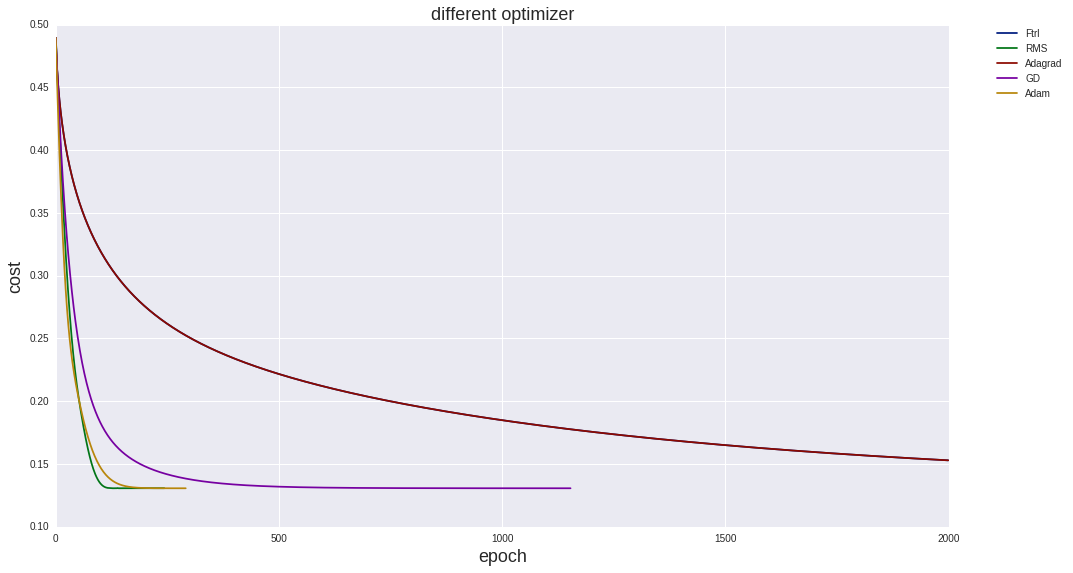

In [16]:
epoch = 2000
alpha = 0.01

optimizer={'GD': tf.train.GradientDescentOptimizer,
           'Adagrad': tf.train.AdagradOptimizer,
           'Adam': tf.train.AdamOptimizer,
           'Ftrl': tf.train.FtrlOptimizer,
           'RMS': tf.train.RMSPropOptimizer
          }

fig, ax = plt.subplots(figsize=(16, 9))

for optimizer_name in optimizer:
    opt = optimizer[optimizer_name](learning_rate=alpha)
    opt_operation = opt.minimize(loss)
    
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        loss_data = []
        
        for i in range(epoch):
            _, loss_val = sess.run([opt_operation, loss], feed_dict={X: X_data, y: y_data})
            loss_data.append(loss_val[0,0])  # because every loss_val is 1*1 ndarray

            if len(loss_data) > 1 and np.abs(loss_data[-1] - loss_data[-2]) < 10**-9:
                print('{} is converged at epoch: {}'.format(optimizer_name, i))
                break

    ax.plot(np.arange(len(loss_data)), loss_data, label = optimizer_name)

ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('different optimizer', fontsize=18)
